In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import hvplot.xarray
import geoviews as gv
import geoviews.feature as gf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd

import xopr.opr_access as xopr

In [3]:
# Establish an OPR session
# You'll probably want to set a cache directory if you're running this locally to speed
# up subsequent requests. You can do other things like customize the STAC API endpoint,
# but you shouldn't need to do that for most use cases.
opr = xopr.OPRConnection(cache_dir="radar_cache")

# Or you can open a connection without a cache directory (for example, if you're parallelizing
# this on a cloud cluster without persistent storage).
#opr = xopr.OPRConnection()

In [4]:
# List the available OPR datasets
collections = opr.get_collections()
print([c['id'] for c in collections])
selected_collection = collections[0]['id']  # Select the first collection for demonstration
print(f"Selected collection: {selected_collection}")

['2016_Antarctica_DC8', '2022_Antarctica_BaslerMKB']
Selected collection: 2016_Antarctica_DC8


In [5]:
# List flights in the selected collection
flights = opr.get_flights(selected_collection)
print(f"Available flights in {selected_collection}:")
for flight in flights:
    print(f" - {flight['flight_id']}")

Querying STAC API: https://opr-stac-fastapi-974574526248.us-west1.run.app/search with POST body: {'collections': ['2016_Antarctica_DC8'], 'limit': 500, 'fields': {'exclude': ['geometry', 'bbox']}}
Found 500 features in this page.
Querying STAC API: https://opr-stac-fastapi-974574526248.us-west1.run.app/search with POST body: {'collections': ['2016_Antarctica_DC8'], 'limit': 500, 'fields': {'exclude': ['geometry', 'bbox']}, 'offset': 500}
Found 500 features in this page.
Querying STAC API: https://opr-stac-fastapi-974574526248.us-west1.run.app/search with POST body: {'collections': ['2016_Antarctica_DC8'], 'limit': 500, 'fields': {'exclude': ['geometry', 'bbox']}, 'offset': 1000}
Found 500 features in this page.
Querying STAC API: https://opr-stac-fastapi-974574526248.us-west1.run.app/search with POST body: {'collections': ['2016_Antarctica_DC8'], 'limit': 500, 'fields': {'exclude': ['geometry', 'bbox']}, 'offset': 1500}
Found 128 features in this page.
Available flights in 2016_Antarct

In [6]:
selected_flight = flights[10]['flight_id']  # Select the first flight for demonstration
print(f"Selected flight: {selected_flight}")

frames = opr.load_flight(selected_collection, flight_id=selected_flight)

Selected flight: 20161026_04
Loading 21 frames from flight '20161026_04'...
  Loaded 5/21 frames...
  Loaded 10/21 frames...
  Loaded 15/21 frames...
  Loaded 20/21 frames...
Successfully loaded 21 frames from flight '20161026_04'


In [7]:
# Inspect an individual frame
frames[0]

<xarray.Dataset> Size: 45MB
Dimensions:    (slow_time: 3338, twtt: 3367)
Coordinates:
  * slow_time  (slow_time) datetime64[ns] 27kB 2016-10-26T17:40:06.527554274 ...
  * twtt       (twtt) float64 27kB 0.0 2.02e-08 4.04e-08 ... 6.798e-05 6.8e-05
Data variables:
    Bottom     (slow_time) float64 27kB ...
    Data       (slow_time, twtt) float32 45MB ...
    Elevation  (slow_time) float64 27kB ...
    Heading    (slow_time) float64 27kB ...
    Latitude   (slow_time) float64 27kB -85.97 -85.97 -85.97 ... -86.4 -86.4
    Longitude  (slow_time) float64 27kB -70.08 -70.08 -70.08 ... -68.6 -68.59
    Pitch      (slow_time) float64 27kB ...
    Roll       (slow_time) float64 27kB ...
    Surface    (slow_time) float64 27kB ...
Attributes: (12/21)
    Conventions:          CF-1.8
    title:                Radar Echogram Data
    institution:          Open Polar Radar (OPR)
    source:               Airborne/ground-based radar sounder
    history:              Converted to CF-compliant format on 2025-08-01T21:1...
    references:           https://gitlab.com/openpolarradar/opr
    ...                   ...
    stac_collection:      2016_Antarctica_DC8
    stac_item_id:         CSARP_standard_Data_20161026_04_001
    flight_id:            20161026_04
    opr_date:             20161026
    opr_flight:           4
    opr_segment:          1

In [8]:
# Combine the frames into a single xarray Dataset representing the flight line
flight_line = xr.concat(frames, dim='slow_time', combine_attrs='drop_conflicts')
flight_line

<xarray.Dataset> Size: 950MB
Dimensions:    (slow_time: 70143, twtt: 3367)
Coordinates:
  * slow_time  (slow_time) datetime64[ns] 561kB 2016-10-26T17:40:06.527554274...
  * twtt       (twtt) float64 27kB 0.0 2.02e-08 4.04e-08 ... 6.798e-05 6.8e-05
Data variables:
    Bottom     (slow_time) float64 561kB nan nan nan nan nan ... nan nan nan nan
    Data       (slow_time, twtt) float32 945MB 1.594e-08 2.543e-08 ... 1.998e-22
    Elevation  (slow_time) float64 561kB 7.535e+03 7.534e+03 ... 5.914e+03
    Heading    (slow_time) float64 561kB -3.049 -3.049 -3.049 ... -3.071 -3.071
    Latitude   (slow_time) float64 561kB -85.97 -85.97 -85.97 ... -88.87 -88.87
    Longitude  (slow_time) float64 561kB -70.08 -70.08 -70.08 ... 110.0 110.0
    Pitch      (slow_time) float64 561kB -0.0007225 -0.0007172 ... 0.05121
    Roll       (slow_time) float64 561kB -0.09577 -0.09581 ... -0.01619 -0.01624
    Surface    (slow_time) float64 561kB 3.914e-05 3.914e-05 ... 1.948e-05
Attributes:
    Conventions:      CF-1.8
    title:            Radar Echogram Data
    institution:      Open Polar Radar (OPR)
    source:           Airborne/ground-based radar sounder
    references:       https://gitlab.com/openpolarradar/opr
    comment:          Polar radar echogram data with CF-compliant metadata
    season:           2016_Antarctica_DC8
    segment:          20161026_04
    stac_collection:  2016_Antarctica_DC8
    flight_id:        20161026_04
    opr_date:         20161026
    opr_flight:       4

In [9]:
layers = None
try:
    layers = xopr.get_layers(flight_line)
    layers[1] # Display the surface layer as an example
except Exception as e:
    print(f"Error fetching layers: {e}")

In [10]:
# Plot a map of where the data was collected with a basemap on an EPSG:3031 projection
proj = ccrs.Stereographic(central_latitude=-90, true_scale_latitude=-71)
coords = flight_line[['Longitude', 'Latitude']].to_dataframe().dropna()
(gf.ocean * gf.coastline * gv.Path([coords.values])).opts(projection=proj, aspect='equal')


:Overlay
   .Ocean.I     :Feature   [Longitude,Latitude]
   .Coastline.I :Feature   [Longitude,Latitude]
   .Path.I      :Path   [Longitude,Latitude]

In [11]:
#stacked = flight_line.Data.rolling(slow_time=10, center=True).mean()
stacked = flight_line.Data.resample(slow_time='1s').mean()
pwr_dB = 10*np.log10(np.abs(stacked))

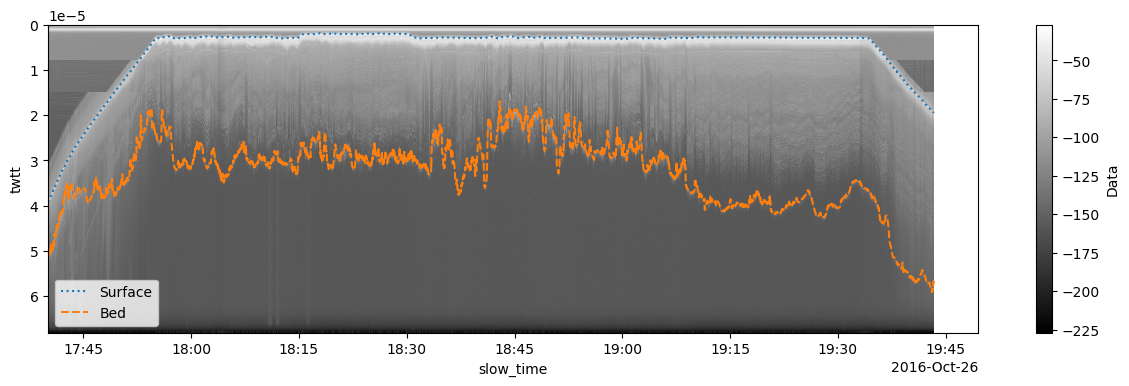

In [12]:
# slow_time_regular = pd.date_range(
# start=pwr_dB.slow_time.min().values,
# end=pwr_dB.slow_time.max().values,
# freq=pd.Timedelta(seconds=0.01)
# )
# pwr_dB_interp = pwr_dB.interp(slow_time=slow_time_regular)

fig, ax = plt.subplots(figsize=(15, 4))
pwr_dB.plot.imshow(x='slow_time', cmap='gray', ax=ax)
ax.invert_yaxis()

if layers:
    layers[1]['twtt'].plot(ax=ax, x='slow_time', linestyle=':', label='Surface')
    layers[2]['twtt'].plot(ax=ax, x='slow_time', linestyle='--', label='Bed')
    ax.legend()

In [13]:
print(xopr.generate_citation(flight_line))

== Data Citation ==
No specific citation information was retrieved for this dataset. By default, please cite:
CReSIS. 2024. REPLACE_WITH_RADAR_NAME Data, Lawrence, Kansas, USA. Digital Media. http://data.cresis.ku.edu/.
== Processing Citation ==
Data was processed using the Open Polar Radar (OPR) Toolbox: https://doi.org/10.5281/zenodo.5683959
Please cite the OPR Toolbox as:
Open Polar Radar. (2024). opr (Version 3.0.1) [Computer software]. https://gitlab.com/openpolarradar/opr/. https://doi.org/10.5281/zenodo.5683959
And include the following acknowledgment:
We acknowledge the use of software from Open Polar Radar generated with support from the University of Kansas, NASA grants 80NSSC20K1242 and 80NSSC21K0753, and NSF grants OPP-2027615, OPP-2019719, OPP-1739003, IIS-1838230, RISE-2126503, RISE-2127606, and RISE-2126468.

